In [29]:
import scipy.io #pacote para carregar dados do matlab
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt #pacote para graficar a la matlab
import numpy as np #pacote de calculo numerico, a la matlab
from pylab import *
import pandas as pd
import os
import h5py
import glob
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

In [6]:
import pyLPD.MLtools as mlt

In [7]:
path=''
file_name = 'example_data_1.h5'
full_path = os.path.join(path,file_name)
data = h5py.File(full_path)
data.visititems(lambda n,o:print(n, o))

Acetylene <HDF5 dataset "Acetylene": shape (401729,), type "<f8">
MZ <HDF5 dataset "MZ": shape (401729,), type "<f8">
Transmission <HDF5 dataset "Transmission": shape (401729,), type "<f8">
Wavelength <HDF5 dataset "Wavelength": shape (401729,), type "<f8">


<IPython.core.display.Javascript object>


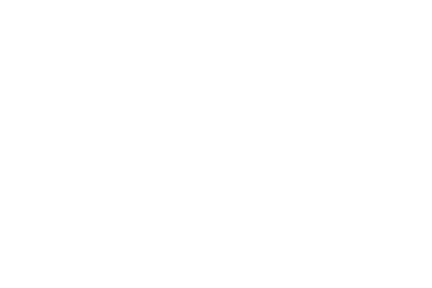

<IPython.core.display.Javascript object>


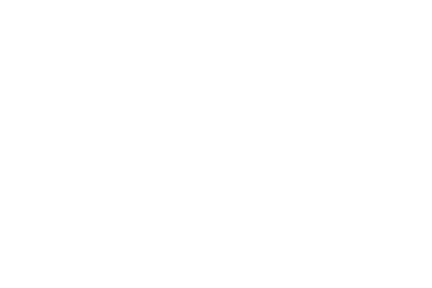

In [24]:
%matplotlib notebook
cav_raw = data['Transmission'][:] # canal 2 do scope, transmissao da cavidade, Volts
mzi_raw = data['MZ'][:] # canal 3 do scope, transmissao do interferometro, Volts
wavelength_raw = data['Wavelength'][:] # canal 3 do scope, transmissao do interferometro, Volts
time_raw = wavelength_raw
mzi_fsr = 'MZI (fsr=7 GHz)'
#normalize
mzi_raw = (mzi_raw - np.min(mzi_raw))/np.max((mzi_raw - np.min(mzi_raw)))
cav_raw = cav_raw/np.max(cav_raw)
#-------
#Graficos
#-------
plt.plot(mzi_raw,label=mzi_fsr ,alpha=0.5)
plt.plot(cav_raw,label='Cavity',color=(1,0,0))
plt.xlabel('Índice')
plt.ylabel('Transmissão (norm.)')
plt.legend(loc='best')

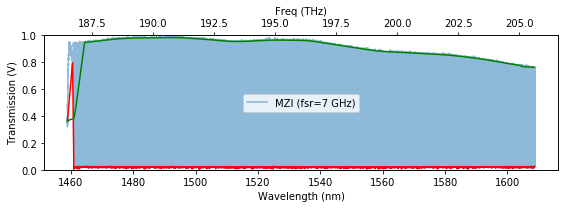

In [26]:
#Switch to inline
%matplotlib inline
#-------
#índices do vetor em torno de uma dada ressonância, escolhido do gráfico anterior
ind_i = 0 #376900
ind_f = len(cav_raw)
#-------
#recortando os vetores de dados
wavelength = wavelength_raw[int(ind_i):int(ind_f)] # canal 1 do scope, tempo em miliseg.
time = wavelength
freq = 3e5/wavelength # canal 1 do scope, tempo em miliseg.
cav = cav_raw[int(ind_i):int(ind_f)]  # canal 2 do scope, transmissao da cavidade, Volts
mzi = mzi_raw[int(ind_i):int(ind_f)]  # canal 3 do scope, transmissao do interferometro, Volts
#-------
#Graficos
#-------
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(wavelength,mzi,label=mzi_fsr,alpha=0.5)
#ax1.plot(wavelength,cav,label='Cavity',color=(1,0,0))
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Transmission (V)')
ax1.set_ylim([0,np.max(cav)])
ax2.plot(freq, -1*np.ones(len(freq))) # Create a dummy plot
ax2.set_xlabel('Freq (THz)')
#plt.show()
ax1.legend(loc='best')
#plt.savefig()
#-------------
# ylower,yupper = mlt.envPeak(cav,delta=0.3, sg_order=0)
# cav_norm = cav/yupper
#--
ylower,yupper = mlt.envPeak(mzi,delta=0.1, sg_order=0)
mzi_norm = mzi/yupper
#plots
ax1.plot(wavelength,ylower,label='low env.',color='red')
ax1.plot(wavelength,yupper,label='low env.',color='green')
plt.tight_layout()

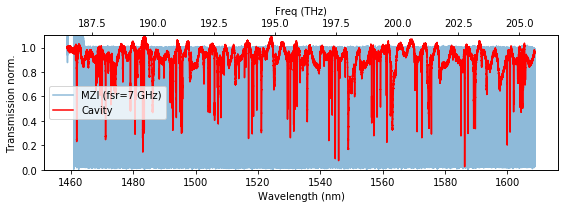

In [19]:
#---------
#Graficos
#---------
fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(wavelength,mzi_norm,label=mzi_fsr,alpha=0.5)
ax1.plot(wavelength,cav_norm,label='Cavity',color=(1,0,0))
ax1.set_xlabel('Wavelength (nm)')
ax1.set_ylabel('Transmission norm.')
ax1.set_ylim([0,1.1])
ax2.plot(freq, -1*np.ones(len(freq))) # Create a dummy plot
ax2.set_xlabel('Freq (THz)')
plt.tight_layout()
#plt.show()
ax1.legend(loc='best')
#plt.savefig()

## Mach-Zehnder wavelength calibration

### First we find all maxima and minima of the MZI transmission

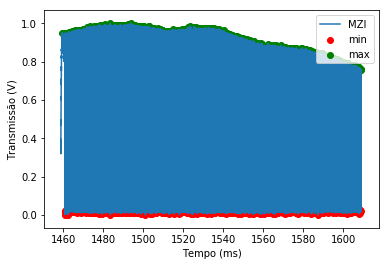

In [35]:
#Switch to inline
%matplotlib inline
delta = 0.5 # parâmetro de seletividade para os mínimos, ajuste conforme necessário
ind_max, maxtab, ind_min, mintab = mlt.peakdet(mzi,delta) 
plt.plot(time,mzi,label='MZI')
plt.scatter(time[ind_min],mintab[:,1],color='r',label='min')
plt.scatter(time[ind_max],maxtab[:,1],color='g',label='max')
plt.xlabel('Tempo (ms)')
plt.ylabel('Transmissão (V)')
plt.legend(loc='best')

Now we create a frequency axis assuming that the spectral distance between a maximum and a consecutive minimum is $\nu_{fsr}/2$. This gives a the corrected frequency but only at the max/min points. To get the frequency at every other point in the spectrum, we create and interpolating function:

In [38]:
#Construindo um eixo de frequências com base em transmissão do MZI
ind_peaks = np.empty((ind_min.size + ind_max.size,), dtype=int)
ind_peaks [0::2] = ind_max
ind_peaks [1::2] = ind_min
#---
freq0 = 0
mzi_fsr = 7000 # MHz
freq_r = freq0 + (0.5*mzi_fsr)*(np.arange(0,len(ind_peaks)) - len(ind_peaks)/2)
#Interpolando 
freq_ifunc = interp1d(time[ind_peaks], freq_r)
#Gerando novos vetores com pontos limitados pelos extremos da interpolação
time_i = time[ind_peaks[0]:ind_peaks[-1]]
freq_i = freq_r[ind_peaks[0]:ind_peaks[-1]]
cav_i = cav_norm[ind_peaks[0]:ind_peaks[-1]]
#mzi_i = mzi_norm[ind_peaks[0]:ind_peaks[-1]]
mzi_i = mzi[ind_peaks[0]:ind_peaks[-1]]
freq_i = freq_ifunc(time_i) 

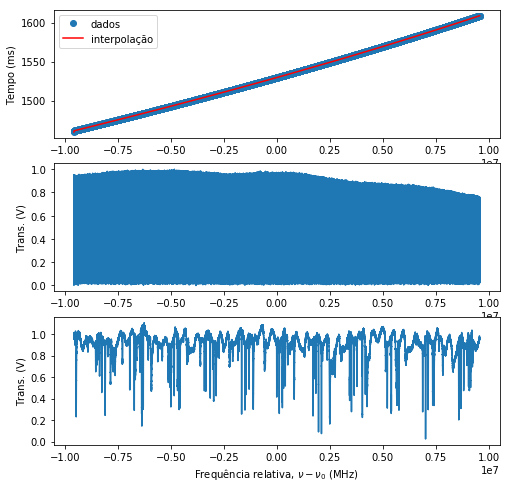

In [39]:
#Graficando
plt.subplots(3,1, sharex=True, figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(freq_r,time[ind_peaks],'o',label='dados')
plt.plot(freq_i,time_i,'r',label='interpolação')
plt.ylabel('Tempo (ms)')
plt.legend(loc='best')
#plt.title(r'Eixo de freq. interpolado, $\nu(t)$, baseado no FSR do MZI')
#-----
plt.subplot(3,1,2)
plt.plot(freq_i,mzi_i,label='interpolação')
#plt.xlabel('Tempo (ms)')
plt.ylabel(r'Trans. (V)')
#-----
plt.subplot(3,1,3)
plt.plot(freq_i,cav_i,label='interpolação')
#plt.xlabel('Tempo (ms)')
plt.ylabel('Trans. (V)')
plt.xlabel(r'Frequência relativa, $\nu-\nu_0$ (MHz)')

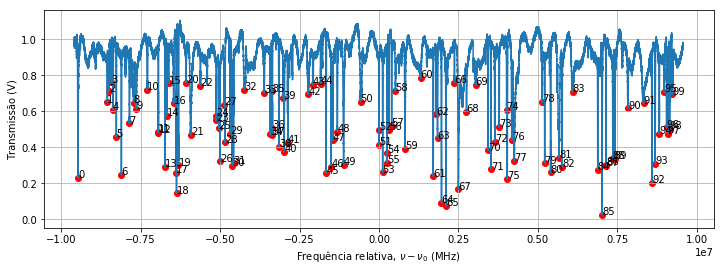

In [52]:
delta = 0.2 # parâmetro de seletividade para os mínimos, ajuste conforme necessário
ind_max, maxtab, ind_min, mintab = mlt.peakdet(cav_i,delta) 
plt.figure(figsize=(12,4))
plt.plot(freq_i,cav_i,label='Cavity')
plt.scatter(freq_i[ind_min],mintab[:,1],color='r')
plt.xlabel(r'Frequência relativa, $\nu-\nu_0$ (MHz)')
plt.ylabel('Transmissão (V)')
plt.grid(True)
ax=plt.gca()
for i in range(0,len(ind_min)):
    ax.annotate(i, (freq_i[ind_min[i]],mintab[i,1]))

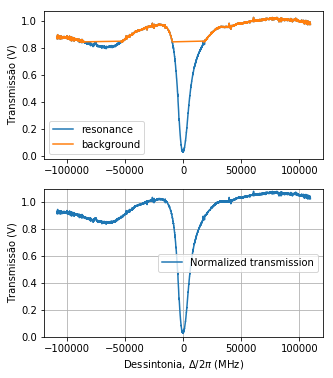

In [84]:
#import peakutils
#-------
#índices do vetor em torno de uma dada ressonância, escolhido do gráfico anterior
ind_0 = ind_min[85] #índice do mínimo, veja na figura anterior
delta_ind = 5e3 # numero de pontos em torno do mínimo
ind_i = ind_0 - int(delta_ind/2)
ind_f = ind_0 + int(delta_ind/2)
#-------
#recortando os vetores de dados
freq_res = freq_i[int(ind_i):int(ind_f)] - freq_i[ind_0] # canal 1 do scope, tempo em miliseg.
mzi_res = mzi_i[int(ind_i):int(ind_f)]  # canal 3 do scope, transmissao do interferometro, Volts
cav_res = cav_i[int(ind_i):int(ind_f)]  # canal 2 do scope, transmissao da cavidade, Volts
#normalizando a ressonancia
nstd=1.0 # numero de desvios-padrão para se ignorar
background_mask = cav_res>(np.max(cav_res)-nstd*np.std(cav_res)) # remove the ressonance peak 
background = np.mean(cav_res[background_mask])
cav_norm = cav_res/background
#-------
#graficando
plt.subplots(2,1,figsize=(5,6))
plt.subplot(2,1,1)
plt.plot(freq_res,cav_res,label='resonance')
plt.plot(freq_res[background_mask],cav_res[background_mask],label='background')
#plt.plot(freq_res,background,label='Cavity')
plt.ylabel('Transmissão (V)')
plt.legend(loc='best')
#--
plt.subplot(2,1,2)
plt.plot(freq_res,cav_norm,label='Normalized transmission')
plt.ylim([0,1.1])
plt.grid(True)
plt.ylabel('Transmissão (V)')
plt.xlabel(r'Dessintonia, $\Delta/2\pi$ (MHz)')
plt.legend(loc='best')

In [93]:
import peakutils

In [99]:

?peakutils.baseline

(0, 1.1)

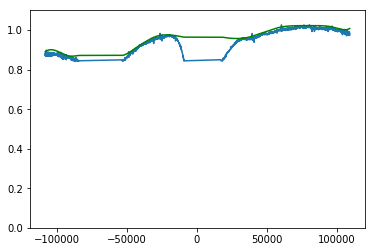

In [109]:
xx=freq_res[background_mask]
yy=-cav_res[background_mask]+2
bl=2-peakutils.baseline(yy,deg=10)
#plots
plt.plot(xx,-yy+2,label='resonance')
plt.plot(xx,bl,label='low env.',color='green')
#plt.plot(freq_res)
plt.ylim([0,1.1])

(0, 1.1)

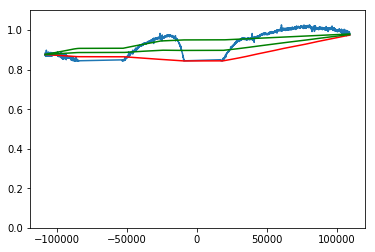

In [92]:
xx=freq_res[background_mask]
yy=cav_res[background_mask]
ylower,yupper = mlt.envPeak(yy,delta=0.1, sg_order=0,interp_kind='slinear')
#plots
plt.plot(xx,yy,label='resonance')
plt.plot(xx,ylower,label='low env.',color='red')
plt.plot(xx,yupper,label='low env.',color='green')
plt.plot(xx,0.5*(ylower+yupper),label='low env.',color='green')
plt.ylim([0,1.1])

In [72]:
?interp1d

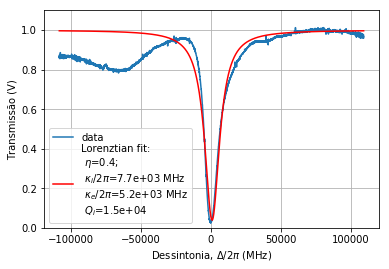

In [56]:
def cav_lorentzian(Delta, delta0, eta, kappa):
    '''
    Single-port cavity lorentzian response
    '''
    j = complex(0,1)
    omega = 2*np.pi*freq
    #----------------
    #----------------
    den = 4*(Delta-delta0)**(2)+kappa**(2)
    num = 4*(Delta-delta0)**(2)+(1-2*eta)**(2)*kappa**(2)
    func =  num/den
    return func
#-------------------------
#ajuste da função aos dados
guess =[0,0.1,10]
pfit, pcov = curve_fit(cav_lorentzian,freq_res,cav_norm,p0=guess)
#-------------------------
#resultado do fitting
eta = pfit[1] # coupling condition
kappa = pfit[2] # total loss (MHz)
kappa_i = kappa*(1-eta) # instrinsic loss (MHz)
kappa_e = kappa*eta # external loss (MHz)
freq_laser = 193e6 # frequencia central do laser, em MHz
Q_i = freq_laser/kappa # fator de qualidade intrínseco
#----------------------
#Graficando os resultados
legenda = 'Lorenztian fit:\n' + \
    r' $\eta$={:2.2g};'.format(eta) + '\n' \
    r' $\kappa_i/2\pi$={:2.2g} MHz'.format(kappa_i) + '\n' +\
    r' $\kappa_e/2\pi$={:2.2g} MHz'.format(kappa_e) + '\n' +\
    r' $Q_i$={:2.2g}'.format(Q_i) 
#--
plt.plot(freq_res,cav_norm,label='data')    
plt.plot(freq_res,cav_lorentzian(freq_res,*pfit),'r',label=legenda)
plt.grid(True)
plt.ylim([0,1.1])
plt.ylabel('Transmissão (V)')
plt.xlabel(r'Dessintonia, $\Delta/2\pi$ (MHz)')
plt.legend(loc='best')